,Index,Slide Image,Extracted Text
0,1,,Drugs used in the pharmacotherapy of GIT disorders.J. Mojzis
1,2,,Peptic ulcerGastric mucosa -a sensitive balance of factors preventing self-digestionProtective factors- bicarbonate- mucus- blood supply- epithelial cell regenerationAggressive factors- HCl- pepsin- bile acids- H. pylori- ROS
2,3,,
3,4,,Peptic ulcer - cont.H. pyloriBile refluxStressProstaglandin synthesis inhibitorsGlucocorticoidsAlcoholSmokingBlood flow disturbancy
4,5,,Gastric ulcer in the antrum of the stomach with overlying clot.

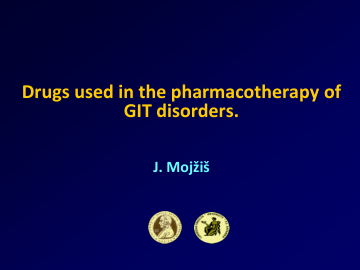
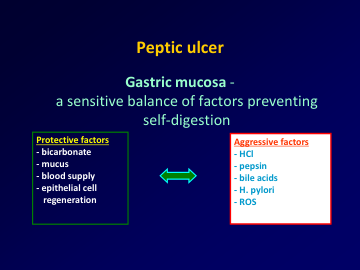
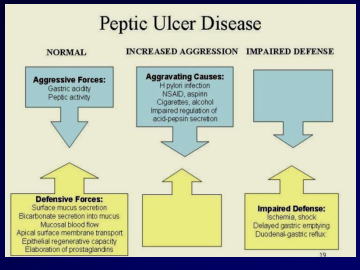
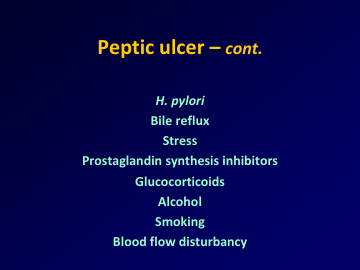
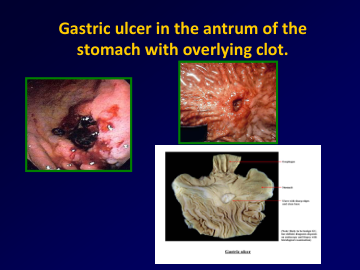

Extracted text saved to extracted_text/extracted_presentation_text.txt


In [27]:
import os
import glob
import fitz  # PyMuPDF
import pandas as pd
from PIL import Image
import io
import base64
from IPython.display import display, HTML
import ftfy  # Fix text for you
import unidecode  # Normalize unicode to ASCII

class PresentationLoader:
    def __init__(self, materials_folder):
        self.materials_folder = materials_folder
        self.pdf_file = self.get_latest_pdf()
        self.images = []
        self.texts = []
        self.df = None
        
    def get_latest_pdf(self):
        """Get the latest PDF file from the materials folder."""
        list_of_files = glob.glob(os.path.join(self.materials_folder, '*.pdf'))
        if not list_of_files:
            raise FileNotFoundError("No PDF files found in the materials folder.")
        latest_file = max(list_of_files, key=os.path.getctime)
        return latest_file
    
    def load_pdf(self):
        """Load the PDF, extract the images and text for each page."""
        doc = fitz.open(self.pdf_file)
        
        # Extract text and images from each page
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text = page.get_text("text")
            
            # Clean up the text
            cleaned_text = self.clean_text(text)
            self.texts.append(cleaned_text)
            
            # Convert page to image and scale it
            pix = page.get_pixmap(matrix=fitz.Matrix(0.5, 0.5))
            
            # Convert to PIL Image and store in memory
            img = Image.open(io.BytesIO(pix.tobytes()))
            
            # Convert image to base64 for embedding in HTML DataFrame
            buffer = io.BytesIO()
            img.save(buffer, format="PNG")
            img_str = base64.b64encode(buffer.getvalue()).decode()
            
            # Display the scaled-up image
            img_html = f'<img src="data:image/png;base64,{img_str}"/>'
            self.images.append(img_html)
            
    def clean_text(self, text):
        """Clean up the text by normalizing and fixing strange characters."""
        # Fix text encoding issues
        text = ftfy.fix_text(text)
        
        # Convert strange Unicode characters to plain ASCII if possible
        text = unidecode.unidecode(text)
        
        # Don't replace \n with spaces, we preserve newlines
        # Ensure newline characters are preserved properly
        text = text.replace('\\n', '\n')  # Just in case it's escaped
        
        return text
    
    def create_dataframe(self):
        """Create a DataFrame with index, image, and text."""
        data = []
        for i, (image, text) in enumerate(zip(self.images, self.texts)):
            data.append({
                'Index': i+1,
                'Slide Image': image,
                'Extracted Text': text.replace('\n', '<br>')  # For HTML display, use <br> for newlines
            })
            
        self.df = pd.DataFrame(data)
        
    def display_slides(self):
        """Display the DataFrame with images and texts."""
        # Set pandas options to display all text without truncation
        pd.set_option('display.max_colwidth', None)
        pd.set_option('display.max_rows', None)
        
        # Render DataFrame as HTML with images embedded and newlines preserved
        display(HTML(self.df.head(5).to_html(escape=False).replace("\\n", "<br>")))
    
    def save_extracted_text(self):
        """Save the extracted text from slides into a .txt file."""
        # Create the 'extracted_text' folder if it doesn't exist
        output_folder = 'extracted_text'
        os.makedirs(output_folder, exist_ok=True)
        
        # Generate the output file path
        output_file = os.path.join(output_folder, 'extracted_presentation_text.txt')
        
        # Open the file for writing
        with open(output_file, 'w', encoding='utf-8') as f:
            # Write the extracted text with slide headers
            for i, text in enumerate(self.texts):
                f.write(f"Slide {i+1}:\n")
                f.write(text)
                f.write("\n\n")  # Add two newlines between each slide's text
                
        print(f"Extracted text saved to {output_file}")

# Usage
materials_folder = './materials'  # Replace with the path to your materials folder
loader = PresentationLoader(materials_folder)

# Load the PDF and process
loader.load_pdf()

# Create the DataFrame
loader.create_dataframe()

# Display the slides with images and text in the DataFrame
loader.display_slides()

# Save the extracted text to a file
loader.save_extracted_text()

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'
Prompt cost: $0.002262
Completion cost: $0.000890
Prompt cost: $0.002262
Completion cost: $0.000900
Prompt cost: $0.002217
Completion cost: $0.002060
Prompt cost: $0.002265
Completion cost: $0.000940
Prompt cost: $0.002265
Completion cost: $0.001330
Prompt cost: $0.002265
Completion cost: $0.001140
Prompt cost: $0.002285
Completion cost: $0.000840
Prompt cost: $0.002285
Completion cost: $0.000700
Prompt cost: $0.002285
Completion cost: $0.000710
Prompt cost: $0.002230
Completion cost: $0.001820
Prompt cost: $0.002217
Completion cost: $0.001770
Prompt cost: $0.002332
Completion cost: $0.000630
Prompt cost: $0.002332
Completion cost: $0.000700
Prompt cost: $0.002385
Completion cost: $0.000930
Prompt cost: $0.002292
Completion cost: $0.001570


,Slide Number,Slide Preview,Extracted Text,Embedded Image,Resolution,Image Size,Is Relevant,Detailed Description
0,1,,Drugs used in the pharmacotherapy of GIT disorders.J. Mojzis,,202x198,12.15 KB,False,"The image is a circular emblem featuring a profile portrait of a man, possibly a historical figure, depicted with a side view of the face. Surrounding the portrait are the words 'UNIVERZITA PAVLA JOZEFA ŠAFÁRIKA KOŠICE' and the years '1795 1861.' The background consists of a contrasting color, giving the emblem a striking appearance."
1,1,,Drugs used in the pharmacotherapy of GIT disorders.J. Mojzis,,201x201,10.64 KB,False,"The image is a circular logo featuring a seated figure holding a dish in one hand and a staff in the other. The figure is stylized and appears to be a classical representation, possibly symbolizing medicine or healing. Around the figure, there is text in Slovak, which translates to 'Medical Faculty of P.J. Šafárik University'. The background is yellow, and the font is black."
2,3,,,,700x493,48.08 KB,True,"The image is a slide titled ""Peptic Ulcer Disease"". It features a diagram depicting three columns, each representing different states related to peptic ulcer disease: Normal, Increased Aggression, and Impaired Defense. Under ""Normal,"" there are two boxes: ""Aggressive Forces"" listing gastric acidity and peptic activity, and ""Defensive Forces"" listing factors such as surface mucus secretion, bicarbonate secretion into mucus, mucosal blood flow, apical surface membrane transport, epithelial regenerative capacity, and elaboration of prostaglandins. Under ""Increased Aggression,"" there's one box labeled ""Aggravating Causes,"" listing H. pylori infection, NSAIDs, aspirin, cigarettes, alcohol, and impaired regulation of acid-pepsin secretion. Under ""Impaired Defense,"" the box lists ischemia, shock, delayed gastric emptying, and duodenal-gastric reflux. Arrows connecting these elements help indicate progression or development of peptic ulcer disease."
3,5,,Gastric ulcer in the antrum of the stomach with overlying clot.,,200x206,10.89 KB,True,"The image shows an endoscopic view of the stomach lining, potentially depicting an area with an irregular surface. In the center, there is a dark, irregularly shaped region that appears to be an ulcer with a clot over it. Surrounding this area, the mucosa has a reddened appearance, possibly indicating inflammation. The texture of the stomach lining is uneven, with some light reflecting off it, highlighting the moist environment."
4,5,,Gastric ulcer in the antrum of the stomach with overlying clot.,,720x576,40.09 KB,True,"The image shows a dissected view of a stomach. The esophagus is labeled at the top, leading down to the stomach. The surface of the stomach is detailed with rugae, which are folds in the stomach lining. There is also a labeled area indicating an 'ulcer with sharp edges and clean base.' This is likely the gastric ulcer referred to in the slide text. The ulceration is located in the region labeled as the stomach, potentially where an antrum ulcer would appear. The image includes notes mentioning the likelihood of the ulcer being benign and the need for endoscopy and biopsy for definitive diagnosis."
5,5,,Gastric ulcer in the antrum of the stomach with overlying clot.,,400x332,36.96 KB,True,"The image depicts an endoscopic view of the stomach lining, with a distinctive ulcer visible. The ulcer is located in the antrum and appears as an irregularly shaped lesion with some redness and inflammation around it. There seems to be a darker area, which could indicate the presence of a clot over the ulcer, as described in the slide text. The surrounding mucosa of the stomach shows natural folds and ridges typical of the gastric lining, with a glossy, wet appearance, typical of the stomach's mucosal surface."
6,7,,"Non-pharmacological therapy- sleep, stress- diet /avoid ""aggressive"" food, caffeine/ - smoking",,108x70,2.50 KB,True,"The image shows a person ly
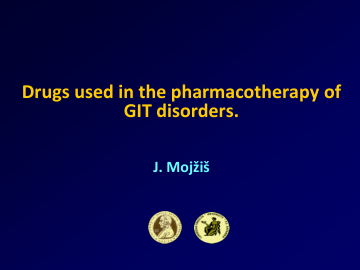
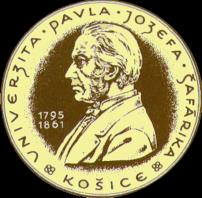
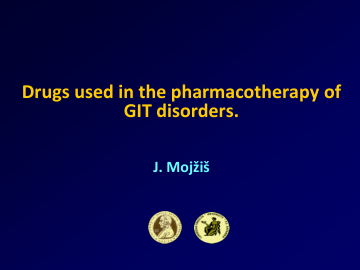
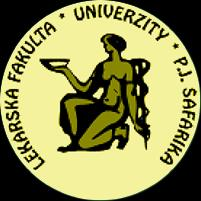
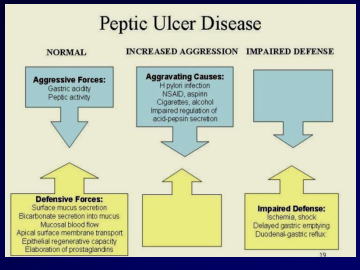
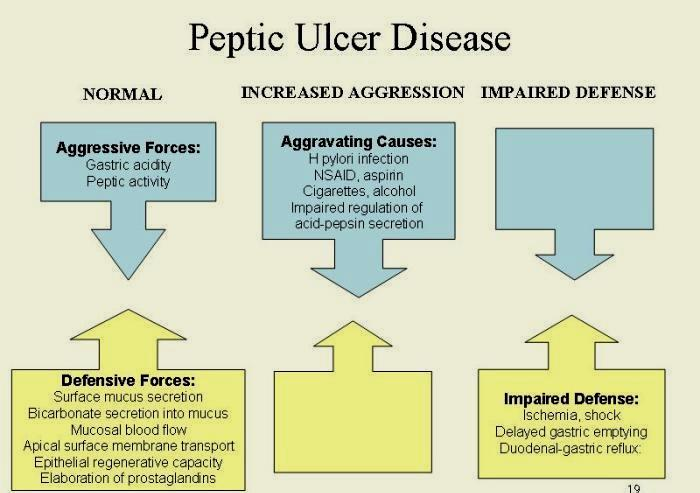
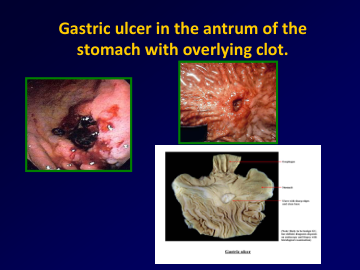
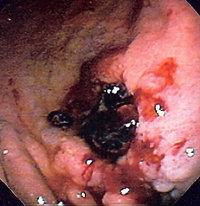
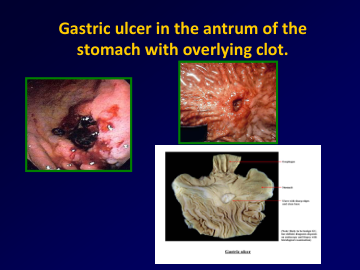
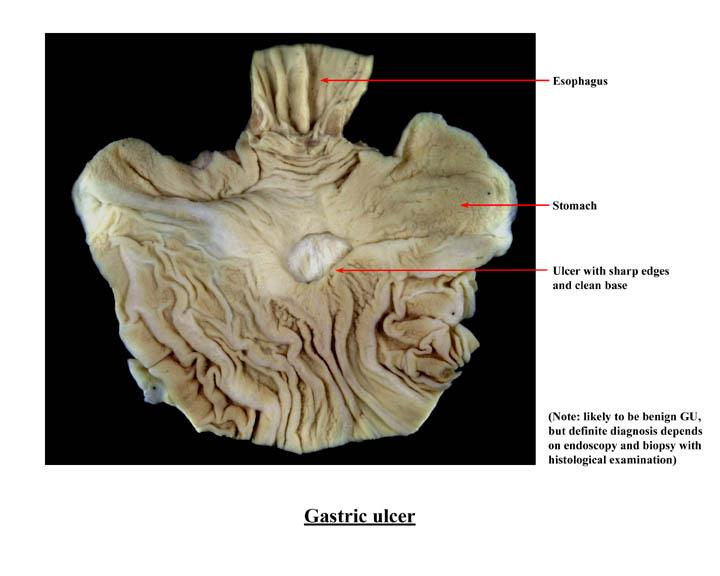
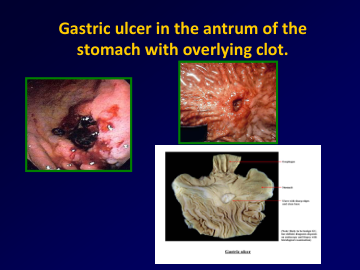
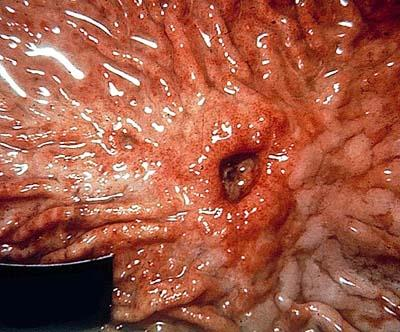
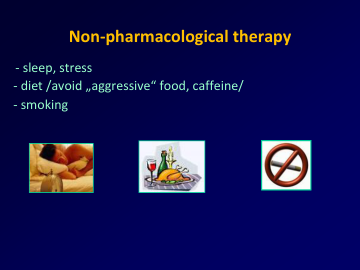
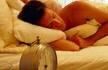
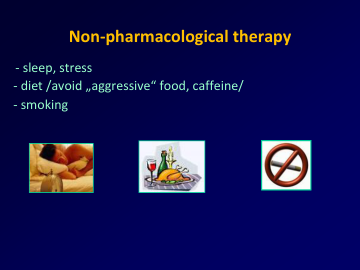
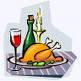
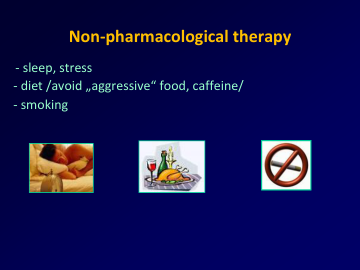
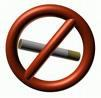
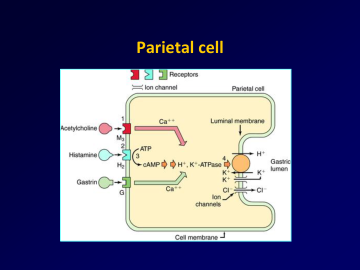
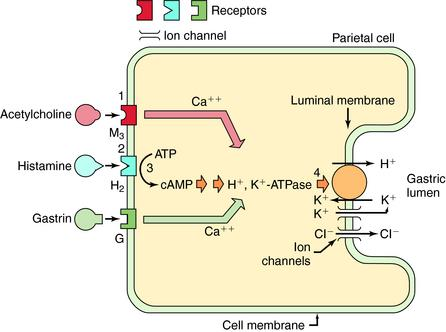
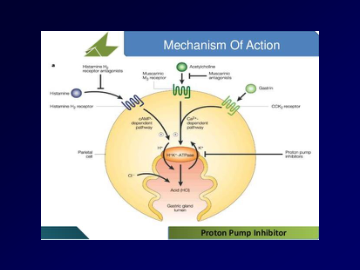
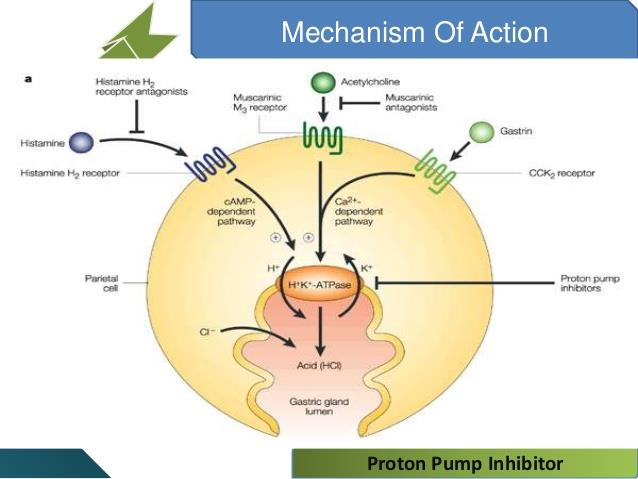
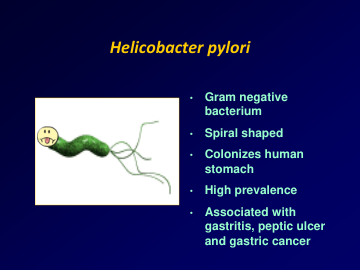
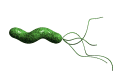
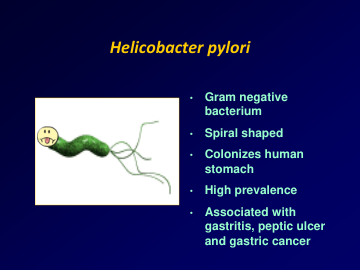
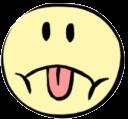
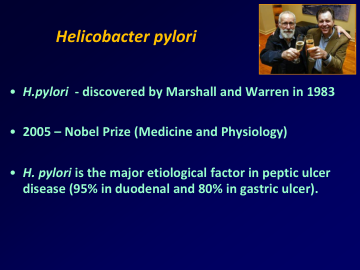
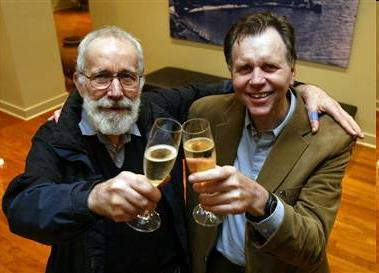
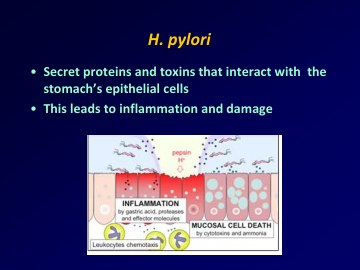
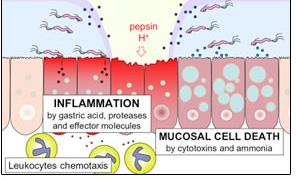

In [50]:
import os
import glob
import fitz  # PyMuPDF
import pandas as pd
from PIL import Image
import io
import base64
from IPython.display import display, HTML
import ftfy  # Fix text for you
import unidecode  # Normalize unicode to ASCII
import tempfile
from tqdm import tqdm
from pydantic import BaseModel

class ImageDescription(BaseModel):
    description: str
    is_relevant: bool

class PresentationLoader:
    def __init__(self, materials_folder):
        self.materials_folder = materials_folder
        self.pdf_file = self.get_latest_pdf()
        self.slide_previews = []
        self.texts = []
        self.embedded_images = []
        self.df = None
        self.client = OpenAIClient(model="gpt-4o-2024-08-06")  # Instantiate API client
        
    def get_latest_pdf(self):
        """Get the latest PDF file from the materials folder."""
        list_of_files = glob.glob(os.path.join(self.materials_folder, '*.pdf'))
        if not list_of_files:
            raise FileNotFoundError("No PDF files found in the materials folder.")
        latest_file = max(list_of_files, key=os.path.getctime)
        return latest_file
    
    def load_pdf(self):
        """Load the PDF, extract the images and text for each page."""
        doc = fitz.open(self.pdf_file)
        
        # Extract text, slide preview images, and embedded images from each page
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text = page.get_text("text")
            
            # Clean up the text
            cleaned_text = self.clean_text(text)
            self.texts.append(cleaned_text)
            
            # Convert page to image and scale it (slide preview)
            pix = page.get_pixmap(matrix=fitz.Matrix(0.5, 0.5))
            img = Image.open(io.BytesIO(pix.tobytes()))
            
            # Convert preview image to base64 for embedding in HTML DataFrame
            buffer = io.BytesIO()
            img.save(buffer, format="PNG")
            img_str = base64.b64encode(buffer.getvalue()).decode()
            img_html = f'<img src="data:image/png;base64,{img_str}" width="150"/>'
            self.slide_previews.append(img_html)
            
            # Extract embedded images in the slide
            page_images = page.get_images(full=True)
            embedded_img_data = []
            
            for img_index, img_info in enumerate(page_images):
                xref = img_info[0]  # The image XREF index
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]
                embedded_img = Image.open(io.BytesIO(image_bytes))
                
                # Get image resolution (width x height)
                width, height = embedded_img.size
                resolution = f"{width}x{height}"
                
                # Calculate image size in KB
                size_kb = len(image_bytes) / 1024  # Convert from bytes to kilobytes
                size_str = f"{size_kb:.2f} KB"
                
                # Save the image to a temporary file
                with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_img_file:
                    embedded_img.save(temp_img_file.name)
                    image_path = temp_img_file.name

                    # Check image relevance and get description
                    description_data = self.check_image_relevance(text, image_path)
                    
                    embedded_img_data.append({
                        'image_html': f'<img src="data:image/png;base64,{base64.b64encode(image_bytes).decode()}" width="150"/>',
                        'resolution': resolution,
                        'size': size_str,
                        'is_relevant': description_data.is_relevant,
                        'description': description_data.description
                    })
            
            self.embedded_images.append(embedded_img_data)  # Store list of embedded images data per slide
    
    def clean_text(self, text):
        """Clean up the text by normalizing and fixing strange characters."""
        # Fix text encoding issues
        text = ftfy.fix_text(text)
        
        # Convert strange Unicode characters to plain ASCII if possible
        text = unidecode.unidecode(text)
        
        # Preserve newlines
        text = text.replace('\\n', '\n')
        
        return text
        
    def check_image_relevance(self, slide_text, image_path):
        """Check the relevance of the image to the slide text using an API."""
        # Define system and user messages
        system_message = "You are an assistant that analyzes images for relevance to slide text. Relevant images add meaningful content, such as graphs, experimental photos, or text."
        user_message = f"The slide says: {slide_text}. Please describe the image in great detail and tell me if it's relevant."
    
        # Call the API with the image and text
        response = self.client.chat(
            system_message=system_message,
            user_message=user_message,
            image_path=image_path,
            response_format=ImageDescription
        )
        
        # Access the parsed response directly
        return response.choices[0].message.parsed

    
    def create_dataframe(self):
        """Create a DataFrame with rows duplicated for each embedded image, including relevance."""
        data = []
        for i, (slide_preview, text, embedded_images) in enumerate(zip(self.slide_previews, self.texts, self.embedded_images)):
            if embedded_images:  # Only process slides that have embedded images
                for img_data in embedded_images:
                    data.append({
                        'Slide Number': i+1,
                        'Slide Preview': slide_preview,
                        'Extracted Text': text.replace('\n', '<br>'),  # For HTML display, use <br> for newlines
                        'Embedded Image': img_data['image_html'],  # Each row gets one embedded image
                        'Resolution': img_data['resolution'],
                        'Image Size': img_data['size'],
                        'Is Relevant': img_data['is_relevant'],
                        'Detailed Description': img_data['description']
                    })
        
        self.df = pd.DataFrame(data)
    
    def display_slides(self):
        """Display the DataFrame with slide previews, extracted texts, and embedded images."""
        # Set pandas options to display all text without truncation
        pd.set_option('display.max_colwidth', None)
        pd.set_option('display.max_rows', None)
        
        # Render DataFrame as HTML with custom row styling
        display(HTML(self.df.to_html(escape=False).replace("\\n", "<br>")))


# Usage
materials_folder = './materials'  # Replace with the path to your materials folder
loader = PresentationLoader(materials_folder)

# Load the PDF and process
loader.load_pdf()

# Create the DataFrame
loader.create_dataframe()

# Display the slides with images and text in the DataFrame
loader.display_slides()

# Chapters and Concepts Extractions

## Extract with JSON Format

In [46]:
prompt = """
You are an expert at extracting topics and concepts from medical presentations.

**Task:**
Given the transcription text of a medical presentation, your task is to:
1. **Identify all main topics** covered in the presentation.
2. **List all associated concepts** under each topic.
3. **Ensure that all material (subjects and concepts and sub-concepts) from the presentation is included** in your output.
4. **Do not add any information** that is not present in the transcription text.
5. **Present the information in a clear, structured format** as specified below.

**Instructions:**

- **Reading the Text:**
  - Read the transcription text carefully.
  - For each slide or section, determine if it introduces a new topic or adds concepts to an existing topic.

- **Formatting Guidelines:**
  - **Topics:**
    - Use **title case** for topic titles (capitalize the first letter of each major word).
    - Ensure topic titles are concise and accurately reflect the content.
  - **Concepts:*
    - Use **sentence case** for concepts (capitalize only the first word of the sentence and proper nouns).
    - Write concepts as **concise phrases**, avoiding full sentences.
    - Organize concepts in a logical order as they appear in the presentation.

- **Medical Terminology:**
  - Use **accurate and consistent medical terminology**.
  - **Spell out** abbreviations upon first mention with the abbreviation in parentheses if they are commonly used (e.g., "Proton Pump Inhibitors (PPIs)").
  - Use **correct capitalization** for medical terms (e.g., "Helicobacter pylori", "Prostaglandin E₂").
  - Ensure all drug names, biological terms, and medical conditions are spelled correctly.

- **Consistency:**
  - Maintain consistent formatting throughout the document.
  - Use consistent terminology and phrasing for similar concepts.

- **Order and Structure:**
  - Maintain the **sequence of topics and concepts** as they appear in the presentation to preserve the logical flow.
  - **Group related concepts** under the appropriate topic.
  - Avoid duplications unless a concept is expanded upon in a different context.

- **Additional Guidelines:**

  - **Handling Repetition:**
    - If a concept or topic is mentioned multiple times, include it only **once** unless new information is provided.
  - **Slides with No Text:**
    - If a slide lacks text but is referenced in the transcription, include any **relevant concepts** mentioned.

  - **Figures and Images:**
    - If the transcription refers to figures or images, include any concepts or descriptions provided.

  - **Completeness:**
    - Ensure **no material is overlooked**; capture all topics and concepts presented.

  - **Style:**
    - Be **concise** and avoid unnecessary words.
    - Do **not** include personal opinions, interpretations, or additional explanations.

---

**Example Output:**

**Topic: Peptic Ulcer Disease**

Concepts:
- Balance of protective and aggressive factors in gastric mucosa
- Protective factors: bicarbonate, mucus, blood supply, epithelial cell regeneration
- Aggressive factors: hydrochloric acid (HCl), pepsin, bile acids, *Helicobacter pylori* (H. pylori), reactive oxygen species (ROS)
- Contributing factors: H. pylori infection, bile reflux, stress
- Impact of prostaglandin synthesis inhibitors, glucocorticoids, alcohol, smoking, blood flow disturbances
- Gastric ulcer observed in the antrum of the stomach with overlying clot

**Topic: Regulation of Gastric Acid Secretion**

Concepts:
- Role of parietal cells in acid secretion
- Regulatory substances stimulating secretion: gastrin, histamine, acetylcholine
- Inhibitory effects of prostaglandins E₂ and I₂ on acid secretion

**Topic: Non-Pharmacological Therapy for Peptic Ulcer**

Concepts:
- Importance of adequate sleep and stress management
- Dietary considerations: avoiding aggressive foods and caffeine
- Smoking cessation recommendations

**Topic: Pharmacological Treatment of Peptic Ulcer**

Concepts:
- Antisecretory drugs: proton pump inhibitors (PPIs), H₂-receptor blockers, parasympatholytics
- Antacids: aluminum hydroxide, magnesium hydroxide, calcium carbonate, sodium bicarbonate
- Cytoprotective agents: prostaglandins, sucralfate, colloidal bismuth
- Anti-Helicobacter pylori medications
"""

In [30]:
import openai
from typing import List, Dict
from dotenv import load_dotenv
import os
import json

# Load environment variables from a .env file
load_dotenv()

# Set your OpenAI API key from the environment variable
openai.api_key = os.getenv('OPENAI_API_KEY')

class MedicalPresentationProcessor:
    def __init__(self, model: str = "gpt-4o-2024-08-06"):
        self.model = model

    def extract_topics_and_concepts(self, text: str) -> List[Concept]:
        # Create the messages for the chat completion
        messages = [
            {
                "role": "system",
                "content": prompt
            },
            {
                "role": "user",
                "content": text
            }
        ]

        # Call the OpenAI API with structured output
        response = openai.chat.completions.create(
            model=self.model,
            messages=messages,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "medical_presentation_extraction",
                    "schema": {
                        "type": "object",
                        "properties": {
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "topic": {"type": "string"},
                                        "concepts": {
                                            "type": "array",
                                            "items": {"type": "string"}
                                        }
                                    },
                                    "required": ["topic", "concepts"],
                                    "additionalProperties": False
                                }
                            }
                        },
                        "required": ["topics"],
                        "additionalProperties": False
                    },
                    "strict": True
                }
            }
        )

        # Parse the response
        assistant_message = response.choices[0].message
        try:
            # Attempt to parse the content of the assistant's message
            parsed_response = json.loads(assistant_message.content)
            
            # Return the topics from the parsed response
            return parsed_response.get("topics", [])
            
        except json.JSONDecodeError:
            print("An error occurred while parsing the response content.")
            return []

# Example usage
if __name__ == "__main__":
    # Read the transcription text from a file
    file_path = "extracted_text/extracted_presentation_text.txt"
    
    with open(file_path, 'r', encoding='utf-8') as file:
        transcription_text = file.read()

    # with open(file_path, 'r', encoding='utf-8') as file:
    #     lines = []
    #     for i in range(100):
    #         line = file.readline()
    #         if not line:
    #             break
    #         lines.append(line.strip())
    # transcription_text = '\n'.join(lines)

    # Initialize the processor
    processor = MedicalPresentationProcessor()

    # Extract topics and concepts
    topics_and_concepts = processor.extract_topics_and_concepts(transcription_text)

    # Output the results
    for item in topics_and_concepts:
        print(f"Topic: {item['topic']}")
        print("Concepts:")
        for concept in item['concepts']:
            print(f"- {concept}")
        print()

Topic: Pharmacotherapy of Gastrointestinal Disorders
Concepts:
- drugs used in the treatment of gastrointestinal disorders
- J. Mojzis

Topic: Peptic Ulcer
Concepts:
- balance of protective and aggressive factors in gastric mucosa
- protective factors: bicarbonate, mucus, blood supply, epithelial cell regeneration
- aggressive factors: HCl, pepsin, bile acids, Helicobacter pylori (H. pylori), reactive oxygen species (ROS)
- contributing factors: H. pylori infection, bile reflux, stress, prostaglandin synthesis inhibitors, glucocorticoids, alcohol, smoking, blood flow disturbance
- gastric ulcer in the antrum of the stomach with overlying clot

Topic: Regulation of Gastric Acid Secretion
Concepts:
- role of parietal cells in acid secretion
- regulatory substances: gastrin, histamine, acetylcholine, prostaglandins E2, I2

Topic: Non-Pharmacological Therapy for Peptic Ulcer
Concepts:
- importance of sleep and stress management
- dietary considerations: avoiding aggressive foods and caffei

## Adding Sub-Concepts with Pydantic

In [7]:
# Prompt with sub-concepts
prompt = """
You are an expert at extracting topics and concepts from medical presentations.

**Task:**
Given the transcription text of a medical presentation, your task is to:
1. **Identify all main topics** covered in the presentation.
2. **List all associated concepts** under each topic.
3. **Ensure that all material (subjects and concepts) from the presentation is included** in your output.
4. **Do not add any information** that is not present in the transcription text.
5. **Present the information in a clear, structured format** as specified below.

**Instructions:**

- **Reading the Text:**
  - Read the transcription text carefully.
  - For each slide or section, determine if it introduces a new topic or adds concepts to an existing topic.

- **Formatting Guidelines:**
  - **Topics:**
    - Use **title case** for topic titles (capitalize the first letter of each major word).
    - Ensure topic titles are concise and accurately reflect the content.
  - **Concepts and subconcepts:**
    - Use **sentence case** for concepts (capitalize only the first word of the sentence and proper nouns).
    - Write concepts as **concise phrases**, avoiding full sentences.
    - Organize concepts in a logical order as they appear in the presentation.
  - 
    - Format like concepts.
    - If necessary, use sub-bullet points to indicate sub-concepts or details under a main concept.

- **Medical Terminology:**
  - Use **accurate and consistent medical terminology**.
  - **Spell out** abbreviations upon first mention with the abbreviation in parentheses if they are commonly used (e.g., "Proton Pump Inhibitors (PPIs)").
  - Use **correct capitalization** for medical terms (e.g., "Helicobacter pylori", "Prostaglandin E₂").
  - Ensure all drug names, biological terms, and medical conditions are spelled correctly.

- **Consistency:**
  - Maintain consistent formatting throughout the document.
  - Use consistent terminology and phrasing for similar concepts.

- **Order and Structure:**
  - Maintain the **sequence of topics and concepts** as they appear in the presentation to preserve the logical flow.
  - **Group related concepts** under the appropriate topic.
  - Avoid duplications unless a concept is expanded upon in a different context.

- **Additional Guidelines:**

  - **Handling Repetition:**
    - If a concept or topic is mentioned multiple times, include it only **once** unless new information is provided.
  - **Slides with No Text:**
    - If a slide lacks text but is referenced in the transcription, include any **relevant concepts** mentioned.

  - **Figures and Images:**
    - If the transcription refers to figures or images, include any concepts or descriptions provided.

  - **Completeness:**
    - Ensure **no material is overlooked**; capture all topics and concepts presented.

  - **Style:**
    - Be **concise** and avoid unnecessary words.
    - Do **not** include personal opinions, interpretations, or additional explanations.

---

**Example Output:**

**Topic: Peptic Ulcer Disease**

Concepts:
- Balance of protective and aggressive factors in gastric mucosa:
  - Protective factors: bicarbonate, mucus, blood supply, epithelial cell regeneration
  - Aggressive factors: hydrochloric acid (HCl), pepsin, bile acids, Helicobacter pylori (H. pylori), reactive oxygen species (ROS)
- Contributing factors:
  - H. pylori infection
  - Bile reflux
  - Stress
- Impact of prostaglandin synthesis inhibitors, glucocorticoids, alcohol, smoking, blood flow disturbances
- Gastric ulcer observed in the antrum of the stomach with overlying clot

**Topic: Regulation of Gastric Acid Secretion**

Concepts:
- Role of parietal cells in acid secretion
- Regulatory substances stimulating secretion:
  - Gastrin
  - Histamine
  - Acetylcholine
- Inhibitory effects of prostaglandins E₂ and I₂ on acid secretion

**Topic: Non-Pharmacological Therapy for Peptic Ulcer**

Concepts:
- Importance of adequate sleep and stress management
- Dietary considerations:
  - Avoiding aggressive foods (e.g., spicy food, acidic food)
  - Caffeine reduction
- Smoking cessation recommendations

**Topic: Pharmacological Treatment of Peptic Ulcer**

Concepts:
- Antisecretory drugs:
  - Proton pump inhibitors (PPIs)
  - H₂-receptor blockers
  - Parasympatholytics
- Antacids:
  - Aluminum hydroxide
  - Magnesium hydroxide
  - Calcium carbonate
  - Sodium bicarbonate
- Cytoprotective agents:
  - Prostaglandins
  - Sucralfate
  - Colloidal bismuth
- Anti-Helicobacter pylori medications
"""

In [40]:
import os
import openai
from dotenv import load_dotenv
from typing import List, Optional
from pydantic import BaseModel
from cost_calculator import CostCalculator

# Load environment variables from a .env file
load_dotenv()

# Set your OpenAI API key from the environment variable
openai.api_key = os.getenv('OPENAI_API_KEY')

# Define the Pydantic model for the response structure
class Concept(BaseModel):
    concept: str
    sub_concepts: Optional[List[str]] = None 
    
class Topic(BaseModel):
    topic: str
    concepts: List[Concept]

class TopicsResponse(BaseModel):
    topics: List[Topic]

# class OpenAIClient:
#     """Helper class to interact with OpenAI API."""

#     def __init__(self, model: str = "gpt-4o-2024-08-06", show_prices: bool = True):
#         self.model = model
#         self.show_prices = show_prices
#         self.cost_calculator = CostCalculator(self.model)

#     def _prepare_messages(self, system_message: str, user_message: str, image_url: Optional[str] = None):
#         """Prepare messages to be sent to the API."""
#         messages = [{"role": "system", "content": system_message}]
        
#         if image_url:
#             user_content = [
#                 {"type": "text", "text": user_message},
#                 {"type": "image_url", "image_url": {"url": image_url}},
#             ]
#         else:
#             user_content = user_message
        
#         messages.append({"role": "user", "content": user_content})
#         return messages

#     def _build_api_payload(self, messages, response_format: Optional[BaseModel] = None):
#         """Build the payload for the OpenAI API request."""
#         api_payload = {
#             "model": self.model,
#             "messages": messages,
#             # "max_tokens": 300  # Default max tokens, can be customized as needed
#         }
#         if response_format:
#             api_payload["response_format"] = response_format
        
#         return api_payload

#     def chat(self, system_message: str, user_message: str, image_url: Optional[str] = None, response_format: Optional[BaseModel] = None):
#         """Main method to send a chat request to OpenAI with optional image input."""
#         # Prepare messages
#         messages = self._prepare_messages(system_message, user_message, image_url)

#         # Calculate and display the prompt cost if required
#         if self.show_prices:
#             full_prompt = system_message + user_message
#             has_image = image_url is not None
#             prompt_cost = self.cost_calculator.calculate_prompt_cost(full_prompt, has_image=has_image)
#             print(f"Prompt cost: ${prompt_cost:.6f}")

#         # Build API payload
#         api_payload = self._build_api_payload(messages, response_format)

#         # Make API call and handle errors
#         try:
#             response = openai.beta.chat.completions.parse(**api_payload)
#         except Exception as e:
#             print(f"Error calling OpenAI API: {e}")
#             return None

#         # Calculate and display the completion cost if required
#         if response and self.show_prices and response.choices:
#             completion_text = response.choices[0].message.content
#             completion_cost = self.cost_calculator.calculate_completion_cost(completion_text)
#             print(f"Completion cost: ${completion_cost:.6f}")

#         return response


import base64
from typing import Optional
from pydantic import BaseModel

class OpenAIClient:
    """Helper class to interact with OpenAI API."""

    def __init__(self, model: str = "gpt-4o-2024-08-06", show_prices: bool = True):
        self.model = model
        self.show_prices = show_prices
        self.cost_calculator = CostCalculator(self.model)

    def _encode_image(self, image_path: str) -> str:
        """Encode an image from a file path to a base64 string."""
        try:
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        except Exception as e:
            print(f"Error encoding image: {e}")
            return None
        
    def _prepare_messages(self, system_message: str, user_message: str, image_path: Optional[str] = None):
        """Prepare messages to be sent to the API, with optional image encoding."""
        messages = [{"role": "system", "content": system_message}]
        
        # If an image path is provided, encode the image and create the image_url
        if image_path:
            base64_image = self._encode_image(image_path)
            if base64_image:
                user_content = [
                    {"type": "text", "text": user_message},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
                ]
            else:
                user_content = user_message
        else:
            user_content = user_message
    
        messages.append({"role": "user", "content": user_content})
        return messages

    def _build_api_payload(self, messages, response_format: Optional[BaseModel] = None):
        """Build the payload for the OpenAI API request."""
        api_payload = {
            "model": self.model,
            "messages": messages,
            # "max_tokens": 300  # Default max tokens, can be customized as needed
        }
        if response_format:
            api_payload["response_format"] = response_format
        
        return api_payload

    def chat(self, system_message: str, user_message: str, image_path: Optional[str] = None, response_format: Optional[BaseModel] = None):
        """Main method to send a chat request to OpenAI with optional image input."""

        # Prepare messages
        messages = self._prepare_messages(system_message, user_message, image_path)

        # Calculate and display the prompt cost if required
        if self.show_prices:
            full_prompt = system_message + user_message
            has_image = image_url is not None
            prompt_cost = self.cost_calculator.calculate_prompt_cost(full_prompt, has_image=has_image)
            print(f"Prompt cost: ${prompt_cost:.6f}")

        # Build API payload
        api_payload = self._build_api_payload(messages, response_format)

        # Make API call and handle errors
        try:
            response = openai.beta.chat.completions.parse(**api_payload)
        except Exception as e:
            print(f"Error calling OpenAI API: {e}")
            return None

        # Calculate and display the completion cost if required
        if response and self.show_prices and response.choices:
            completion_text = response.choices[0].message.content
            completion_cost = self.cost_calculator.calculate_completion_cost(completion_text)
            print(f"Completion cost: ${completion_cost:.6f}")
        return response


class MedicalPresentationProcessor:
    """Processor class to handle topic and concept extraction."""
    def __init__(self, client: OpenAIClient):
        self.client = client

    def extract_topics_and_concepts(self, text: str) -> Optional[TopicsResponse]:
        # Interact with OpenAI API and expect a TopicsResponse structured model
        response = self.client.chat(
            system_message = prompt, 
            user_message = text, 
            response_format = TopicsResponse
        )

        if response:
            return response
        return None

class MainProcessor:
    """Class to manage the full pipeline: reading files, processing, and displaying results."""
    def __init__(self, processor: MedicalPresentationProcessor, file_path: str):
        self.processor = processor
        self.file_path = file_path

    def run(self):
        transcription_text = self._read_file()

        if transcription_text:
            response = self.processor.extract_topics_and_concepts(transcription_text)

            # Access the parsed content in the first choice message
            if response and response.choices and hasattr(response.choices[0].message, 'parsed'):
                topics_and_concepts = response.choices[0].message.parsed

                # Now display the results
                self._display_results(topics_and_concepts)
            else:
                print("No parsed content found in response.")
        else:
            print("No transcription text found.")

    def _read_file(self) -> str:
        """Read and return the contents of the transcription file."""
        try:
            with open(self.file_path, 'r', encoding='utf-8') as file:
                return file.read()
        except FileNotFoundError:
            print(f"File {self.file_path} not found.")
            return ""
    
    def _display_results(self, topics_and_concepts: TopicsResponse):
        """Prints out the topics and concepts, including sub-concepts, extracted from the text."""
        for item in topics_and_concepts.topics:
            print(f"Topic: {item.topic}")
            print("Concepts:")
            for concept in item.concepts:
                # Print the main concept
                print(f"- {concept.concept}")
                # If there are sub-concepts, print them indented
                if concept.sub_concepts:
                    for sub_concept in concept.sub_concepts:
                        print(f"  - {sub_concept}")
            print()  # Add a blank line between topics for readability

if __name__ == "__main__":
    file_path = "extracted_text/extracted_presentation_text.txt"
    
    # Initialize the OpenAI client and processor
    openai_client = OpenAIClient()
    presentation_processor = MedicalPresentationProcessor(openai_client)
    main_processor = MainProcessor(presentation_processor, file_path)
    
    # Run the pipeline
    main_processor.run()

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'
Prompt cost: $0.017430
Completion cost: $0.015630
Topic: Pharmacotherapy of GIT Disorders
Concepts:
- Drugs used for treating GIT disorders

Topic: Peptic Ulcer Disease
Concepts:
- Balance of protective and aggressive factors in gastric mucosa
  - Protective factors: bicarbonate, mucus, blood supply, epithelial cell regeneration
  - Aggressive factors: hydrochloric acid (HCl), pepsin, bile acids, Helicobacter pylori (H. pylori), reactive oxygen species (ROS)
- Contributing factors
  - H. pylori infection
  - Bile reflux
  - Stress
  - Prostaglandin synthesis inhibitors
  - Glucocorticoids
  - Alcohol
  - Smoking
  - Blood flow disturbance
- Observation of gastric ulcer
  - Located in the antrum of the stomach with overlying clot

Topic: Regulation of Gastric Acid Secretion
Concepts:
- Role of parietal cells in acid secretion
- Reg

The result you've provided is very detailed, breaking down complex medical information into clear sub-concepts for each topic. The level of detail is appropriate for an advanced or specialized audience, such as medical students, healthcare professionals, or researchers. However, if the target audience is more general or if the aim is to communicate a broad overview, the concepts might indeed feel too specific or granular.

Here are a few points to consider:
1. **Audience**: If this is meant for an audience with a basic understanding of medicine or laypeople, the concepts could be streamlined. Some of the pharmacokinetic details, mechanisms of drug action, and the extensive list of drug examples might overwhelm non-experts.

2. **Purpose**: If the goal is to provide a quick reference or summary, you could reduce the amount of sub-detail. For example, listing fewer examples of drugs (e.g., just one representative drug per class) and focusing on key therapeutic uses or side effects might improve readability.

3. **Clarity**: The content is clear but can be broken down further with simplified language if needed. Some of the concepts could be merged or summarized. For instance, rather than detailing each type of antacid or laxative, you might group them into categories and mention only significant differences.

To adjust the level of detail, I would suggest identifying the core concepts for each topic and then including only the most relevant sub-concepts. This way, the essential information is conveyed without overwhelming the reader.

# Learning

## Example of Using 'pydantic' as response_format

In [38]:
import openai
from typing import List, Optional
from dotenv import load_dotenv
import os
import json
from pydantic import BaseModel, Field

# Load environment variables from a .env file
load_dotenv()

# Set your OpenAI API key from the environment variable
openai.api_key = os.getenv('OPENAI_API_KEY')

class Webpage(BaseModel):
    """Represents a structured response with parsed webpage content."""
    title: str
    paragraphs: Optional[List[str]] = Field(None, description="Text contents enclosed within <p></p> tags.")
    links: Optional[List[str]] = Field(None, description="URLs specified by `href` field within <a></a> tags.")
    images: Optional[List[str]] = Field(None, description="URLs specified by the `src` field within the <img></img> tags.")

class Webpage(BaseModel):
    title: str
    paragraphs: Optional[List[str]]
    links: Optional[List[str]]
    images: Optional[List[str]]

class Step(BaseModel):
    explanation: str
    output: str

class MathResponse(BaseModel):
    steps: list[Step]
    final_answer: str
class OpenAIClient:
    """Helper class to interact with OpenAI API."""
    def __init__(self, model: str = "gpt-4o-2024-08-06"):
        self.model = model

    def chat(self, system_message: str, user_message: str, response_model: BaseModel):
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message}
        ]

        try:
            # Call the OpenAI API with structured output
            response = openai.beta.chat.completions.parse(
                model=self.model,
                messages=messages,
                response_format=response_model
            )

            return response.choices[0].message.content

        except Exception as e:
            print(f"Error with OpenAI API: {e}")
            return None

class WebpageProcessor:
    """Class to process and extract webpage components using OpenAI."""
    def __init__(self, client: OpenAIClient):
        self.client = client

    def extract_webpage_components(self, html_content: str) -> Webpage:
        system_message = "You are to parse HTML and return the parsed page components."
        
        # Send the HTML content to OpenAI and expect a Webpage structure in return
        response = self.client.chat(system_message, html_content, Webpage)

        if response:
            try:
                # Parse the response to the Webpage model
                parsed_response = json.loads(response)
                webpage = Webpage(**parsed_response)
                
                return webpage
            
            except json.JSONDecodeError:
                print("Error parsing the response from the API.")
        return None

class MainProcessor:
    """Class to manage the whole pipeline: reading files, processing, and displaying results."""
    def __init__(self, processor: WebpageProcessor, file_path: str):
        self.processor = processor
        self.file_path = file_path

    def run(self):
        html_content = self._read_file()

        if html_content:
            webpage = self.processor.extract_webpage_components(html_content)

            # Output the results
            if webpage:
                self._display_results(webpage)

    def _read_file(self) -> str:
        """Read and return the contents of the HTML file."""
        # try:
        #     with open(self.file_path, 'r', encoding='utf-8') as file:
        #         return file.read()
        # except FileNotFoundError:
        #     print(f"File {self.file_path} not found.")
        #     return ""
        return """<html>
                    <title>Structured Outputs Demo</title>
                    <body>
                    <img src="test.gif"></image>
                    <p>Hello world!</p>
                    </body>
                    </html>"""
    
    def _display_results(self, webpage: Webpage):
        """Prints out the parsed webpage components."""
        print(f"Title: {webpage.title}")
        if webpage.paragraphs:
            print("Paragraphs:")
            for paragraph in webpage.paragraphs:
                print(f"- {paragraph}")
        if webpage.links:
            print("Links:")
            for link in webpage.links:
                print(f"- {link}")
        if webpage.images:
            print("Images:")
            for image in webpage.images:
                print(f"- {image}")

if __name__ == "__main__":
    file_path = "path_to_html_file.html"
    
    # Initialize the client and processor
    openai_client = OpenAIClient()
    webpage_processor = WebpageProcessor(openai_client)
    main_processor = MainProcessor(webpage_processor, file_path)
    
    # Run the pipeline
    main_processor.run()


Title: Structured Outputs Demo
Paragraphs:
- Hello world!
Images:
- test.gif


In [81]:
class OpenAIClient:
    """Helper class to interact with OpenAI API."""
    def __init__(self, model: str = "gpt-4o-2024-08-06"):
        self.model = model

    def chat(self, system_message: str, user_message: str, response_model: BaseModel):
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message}
        ]

        try:
            # Call the OpenAI API with structured output
            response = openai.beta.chat.completions.parse(
                model=self.model,
                messages=messages,
                response_format=response_model
            )

            return response.choices[0].message.content

        except Exception as e:
            print(f"Error with OpenAI API: {e}")
            return None

class WebpageProcessor:
    """Class to process and extract webpage components using OpenAI."""
    def __init__(self, client: OpenAIClient):
        self.client = client

    def extract_webpage_components(self, html_content: str) -> Webpage:
        system_message = "You are to parse HTML and return the parsed page components."
        
        # Send the HTML content to OpenAI and expect a Webpage structure in return
        response = self.client.chat(system_message, html_content, Webpage)

        if response:
            try:
                # Parse the response to the Webpage model
                parsed_response = json.loads(response)
                webpage = Webpage(**parsed_response)
                
                return webpage
            
            except json.JSONDecodeError:
                print("Error parsing the response from the API.")
        return None

## Predict API Prices

In [75]:
from tokencost import calculate_prompt_cost, calculate_completion_cost

model = "gpt-4o-2024-08-06"
prompt = [{ "role": "user", "content": "Hello world"}]
completion = "How may I assist you today?"

prompt_cost = calculate_prompt_cost(prompt, model)
completion_cost = calculate_completion_cost(completion, model)

print(f"{prompt_cost} + {completion_cost} = {prompt_cost + completion_cost}")
# 0.0000135 + 0.000014 = 0.0000275

KeyError: 'Model gpt-4o-2024-08-06 is not implemented.\n            Double-check your spelling, or submit an issue/PR'

The prices of the 'tokencost' library are not updated daily, and that is a bug I do not want in my code. I made a decision to implement that library by myself so the functions 'calculate_prompt_cost' and 'calculate_completion_cost' would be plug and play.

I created end-to-end LLM price predior, based on litellm's price chart:

In [139]:
from cost_calculator import CostCalculator

# Initialize the cost calculator with a model that will be resolved to the closest match
cost_calculator = CostCalculator('gpt-4o-2024-08-06')

# Calculate costs
text_prompt = "Hello, how are you today?"
text_completion = "I am doing well, thank you for asking!"

# Calculate prompt cost and completion cost
prompt_cost = cost_calculator.calculate_prompt_cost(text_prompt, has_image=True)
completion_cost = cost_calculator.calculate_completion_cost(text_completion)

# Output the results
print(f"Prompt cost: ${prompt_cost:.6f}")
print(f"Completion cost: ${completion_cost:.6f}")

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'
Prompt cost: $0.002118
Completion cost: $0.000100


Also I added support for input images!

## GPT Vision Cost

In [129]:
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
import matplotlib.pyplot as plt

# Initialize the OpenAI client
client = OpenAI()

# Define the base URL for Cloudinary
base_url = "https://res.cloudinary.com/demo/image/upload/w_{width},h_{height}/sample.jpg"

# Define the range of powers (e.g., from 2^1 to 2^5 for example)
min_power = 6
max_power = 12

# OpenAI pricing per million tokens
price_per_million_tokens = 2.50  # USD

# List to store results
results = []

# Define the total number of iterations (for the progress bar)
total_iterations = (max_power - min_power + 1) ** 2

# Loop through powers of 2 for width (x) and height (y), with a progress bar
for i in tqdm(range(min_power, max_power + 1), desc="Processing image sizes"):
    width = 2 ** i
    height = width

    # Generate the image URL with specified width and height
    image_url = base_url.format(width=width, height=height)

    # Call the OpenAI API
    response = client.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "What’s in this image?"},
                    {
                        "type": "image_url",
                        "image_url": {"url": image_url},
                    },
                ],
            }
        ],
        max_tokens=300,
    )

    # Extract relevant data
    completion_tokens = response.usage.completion_tokens
    prompt_tokens = response.usage.prompt_tokens
    total_tokens = response.usage.total_tokens
    model = response.model
    content = response.choices[0].message.content

    # Calculate the cost for this API call
    cost = (total_tokens / 1_000_000) * price_per_million_tokens

    # Append the data to the results list
    results.append({
        "width": width,
        "height": height,
        "completion_tokens": completion_tokens,
        "prompt_tokens": prompt_tokens,
        "total_tokens": total_tokens,
        "model": model,
        "content": content,
        "cost_usd": cost
    })

# Convert the results list to a DataFrame
df = pd.DataFrame(results)


# Display the DataFrame to the user
display(df)

Processing image sizes: 100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.61s/it]


,width,height,completion_tokens,prompt_tokens,total_tokens,model,content,cost_usd
0,64,64,19,268,287,gpt-4o-2024-08-06,The image shows red and pink flowers with yell...,0.000717
1,128,128,26,268,294,gpt-4o-2024-08-06,The image shows bright pink flowers with yello...,0.000735
2,256,256,31,268,299,gpt-4o-2024-08-06,The image shows vibrant red flowers with yello...,0.000748
3,512,512,32,268,300,gpt-4o-2024-08-06,The image shows vibrant pink flowers with brig...,0.000750
4,1024,1024,28,778,806,gpt-4o-2024-08-06,The image shows bright pink flowers with yello...,0.002015
5,2048,2048,28,778,806,gpt-4o-2024-08-06,The image shows bright pink flowers with yello...,0.002015
6,4096,4096,30,778,808,gpt-4o-2024-08-06,The image shows bright pink and red flowers wi...,0.002020


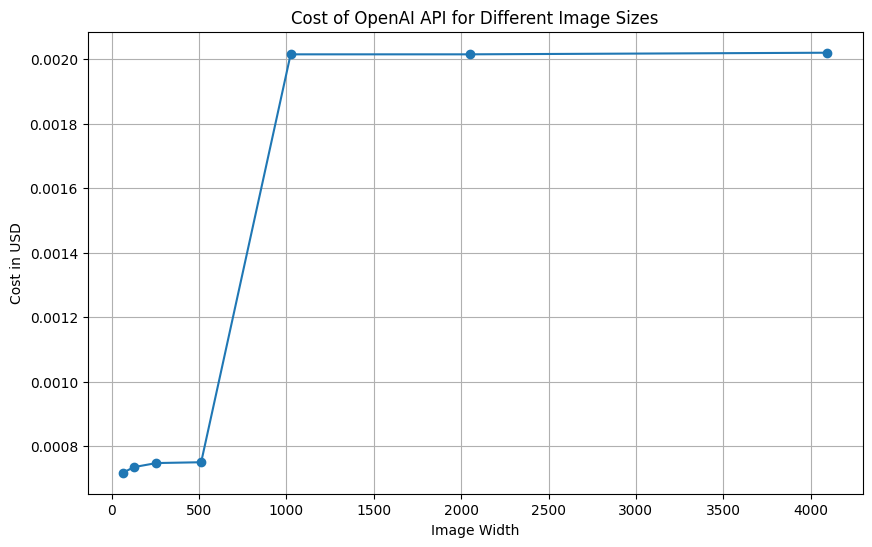

In [130]:
# Plot the cost for each image size
plt.figure(figsize=(10, 6))
plt.plot(df['width'], df['cost_usd'], marker='o')
plt.title('Cost of OpenAI API for Different Image Sizes')
plt.xlabel('Image Width')
plt.ylabel('Cost in USD')
plt.grid(True)
plt.show()

In [131]:
max_price = max(df['cost_usd'])
print(f"Max price of image input to most updated GPT-4o is: {max_price}$")

Max price of image input to most updated GPT-4o is: 0.00202$


In [163]:
# https://medium.com/@teekaifeng/gpt4o-visual-tokenizer-an-illustration-c69695dd4a39
# https://community.openai.com/t/how-do-i-calculate-image-tokens-in-gpt4-vision/492318/5
import math

def calculate_image_tokens(width: int, height: int):
    if width > 2048 or height > 2048:
        aspect_ratio = width / height
        if aspect_ratio > 1:
            width, height = 2048, int(2048 / aspect_ratio)
        else:
            width, height = int(2048 * aspect_ratio), 2048
            
    if width >= height and height > 768:
        width, height = int((768 / height) * width), 768
    elif height > width and width > 768:
        width, height = 768, int((768 / width) * height)

    tiles_width = math.ceil(width / 512)
    tiles_height = math.ceil(height / 512)
    total_tokens = 85 + 170 * (tiles_width * tiles_height)
    
    return total_tokens

print(calculate_image_tokens(40000, 40000) * (2.50 / 1000000))

0.0019125000000000001


In [5]:
import pandas as pd
from openai import OpenAI
import matplotlib.pyplot as plt
import base64
import requests

# Initialize the OpenAI client
client = OpenAI()

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "example.png"

# Getting the base64 string
base64_image = encode_image(image_path)
image_url = f"data:image/jpeg;base64,{base64_image}"

# Call the OpenAI API
response = client.chat.completions.create(
    model="gpt-4o-2024-08-06",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What’s in this image?"},
                {
                    "type": "image_url",
                    "image_url": {"url": image_url},
                },
            ],
        }
    ],
    max_tokens=300,
)

# Extract relevant data
completion_tokens = response.usage.completion_tokens
prompt_tokens = response.usage.prompt_tokens
total_tokens = response.usage.total_tokens
model = response.model
content = response.choices[0].message.content

# Calculate the cost for this API call
price_per_million_tokens = 0.02  # Example value, update as needed
cost = (total_tokens / 1_000_000) * price_per_million_tokens

# Assuming `results` is a predefined list
results = []
results.append({
    "completion_tokens": completion_tokens,
    "prompt_tokens": prompt_tokens,
    "total_tokens": total_tokens,
    "model": model,
    "content": content,
    "cost_usd": cost
})

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame to the user
display(df)

,completion_tokens,prompt_tokens,total_tokens,model,content,cost_usd
0,17,268,285,gpt-4o-2024-08-06,The image shows a person sleeping in a bed wit...,0.000006


In [4]:
df['content'][0]

'The image shows a person sleeping in a bed with a pillow. In the foreground, there is an alarm clock on a bedside surface.'

In [17]:

import base64
from typing import Optional
from pydantic import BaseModel

class OpenAIClient:
    """Helper class to interact with OpenAI API."""

    def __init__(self, model: str = "gpt-4o-2024-08-06", show_prices: bool = True):
        self.model = model
        self.show_prices = show_prices
        self.cost_calculator = CostCalculator(self.model)

    def _encode_image(self, image_path: str) -> str:
        """Encode an image from a file path to a base64 string."""
        try:
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        except Exception as e:
            print(f"Error encoding image: {e}")
            return None
    
    def _prepare_messages(self, system_message: str, user_message: str, image_path: Optional[str] = None):
        """Prepare messages to be sent to the API, with optional image encoding."""
        messages = [{"role": "system", "content": system_message}]
        
        # If an image path is provided, encode the image and create the image_url
        if image_path:
            base64_image = self._encode_image(image_path)
            if base64_image:
                user_content = [
                    {"type": "text", "text": user_message},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
                ]
            else:
                user_content = user_message
        else:
            user_content = user_message
    
        messages.append({"role": "user", "content": user_content})
        return messages

    def _build_api_payload(self, messages, response_format: Optional[BaseModel] = None):
        """Build the payload for the OpenAI API request."""
        api_payload = {
            "model": self.model,
            "messages": messages,
            # "max_tokens": 300  # Default max tokens, can be customized as needed
        }
        if response_format:
            api_payload["response_format"] = response_format
        
        return api_payload

    def chat(self, system_message: str, user_message: str, image_path: Optional[str] = None, response_format: Optional[BaseModel] = None):
        """Main method to send a chat request to OpenAI with optional image input."""

        # Prepare messages
        messages = self._prepare_messages(system_message, user_message, image_path)

        # Calculate and display the prompt cost if required
        if self.show_prices:
            full_prompt = system_message + user_message
            has_image = image_url is not None
            prompt_cost = self.cost_calculator.calculate_prompt_cost(full_prompt, has_image=has_image)
            print(f"Prompt cost: ${prompt_cost:.6f}")

        # Build API payload
        api_payload = self._build_api_payload(messages, response_format)

        # Make API call and handle errors
        try:
            response = openai.beta.chat.completions.parse(**api_payload)
        except Exception as e:
            print(f"Error calling OpenAI API: {e}")
            return None

        # Calculate and display the completion cost if required
        if response and self.show_prices and response.choices:
            completion_text = response.choices[0].message.content
            completion_cost = self.cost_calculator.calculate_completion_cost(completion_text)
            print(f"Completion cost: ${completion_cost:.6f}")
        return response


In [18]:
from pydantic import BaseModel

class ImageDescription(BaseModel):
    description: str
    is_logo_or_meme: bool

# Instantiate the OpenAIClient
client = OpenAIClient(model="gpt-4o-2024-08-06")

# Define system and user messages
system_message = "You are an assistant that describes images."
user_message = "Please describe the image and tell me if it's a logo or meme."

# Specify the image path
image_path = "example.png"

# Make the API call with image and Pydantic response structure
response = client.chat(
    system_message=system_message,
    user_message=user_message,
    image_path=image_path,
    response_format=ImageDescription  # Pass the Pydantic model for output
)

# Print the response
if response:
    print(response.choices[0].message.content)


Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'
Prompt cost: $0.002152
Completion cost: $0.000550
{"description":"The image shows a person sleeping in a bed, resting their head on a pillow, with a vintage-style alarm clock nearby on a bedside table. The room appears to be softly lit, creating a cozy and peaceful atmosphere.","is_logo_or_meme":false}
